# Selecting bins from time, energy

May 2018  
Summer on campus. Entire family swimming in the fountain.

I need to take sums over ranges in time and energy. The challenge is that I can't simply provide an input energy, because that may not correspond to a bin edge. I need to select the energies that correspond to time bin edges.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style='ticks')

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [6]:
%load_ext autoreload
%autoreload 2

# Look at $t \rightarrow E$ conversion

## Look at detector-FC distance distribution

Right now in the time to energy conversion, all of the detectors are using $d=1$ as their distance from the fission chamber to the detector. How accurate is this?

In [7]:
help(bicorr.convert_energy_to_time)

Help on function convert_energy_to_time in module bicorr:

convert_energy_to_time(energy, distance=1)
    Convert energy in MeV to time in ns for neutrons that travel 1 m. From Matthew's `reldist.m` script. 
    
    Parameters
    ----------
    energy : float
        Neutron energy in MeV
    distance : float, optional
        Neutron flight distance in meters
        
    Returns
    -------
    time : float
        Time of flight of neutron



Let's look at the distribution of detector distances. This is stored in an excel file `meas_info > detector_distances.xlsx`.

In [8]:
os.listdir('../meas_info/')

['detector_distances.xlsx',
 'detector_positions.xlsx',
 'det_df.csv',
 'det_df.pkl',
 'det_df_pairs_angles.csv',
 'det_df_pairs_angles.pkl',
 'lanl_detector_angles.mat',
 'lanl_detector_angles_note.md']

In [7]:
det_distance_df = pd.read_excel('../meas_info/detector_distances.xlsx')
det_distance_df.head()

,Channel,Distance (cm)
0,1,106.5
1,2,105.1
2,3,103.8
3,4,103.3
4,5,102.5


Look at a distibution of the detector distances.

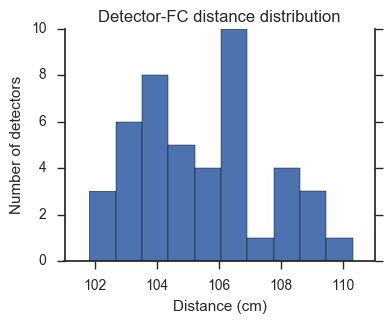

In [8]:
plt.figure(figsize=(4,3))
plt.hist(det_distance_df['Distance (cm)'])
plt.xlabel('Distance (cm)')
plt.ylabel('Number of detectors')
plt.title('Detector-FC distance distribution')
sns.despine(right=False)
plt.show()

Yikes, so my first observation is that the distances are *not* centered around 100! They are, in fact, all greater than 100. So I think even just changing the default distance in `bicorr.convert_time_to_energy` would improve things. 

I'm going to use `pandas.DataFrame.describe` to spit out some metrics: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html

In [9]:
det_distance_df.describe()['Distance (cm)']

count     45.000000
mean     105.522222
std        2.114978
min      101.800000
25%      103.900000
50%      105.300000
75%      106.800000
max      110.300000
Name: Distance (cm), dtype: float64

C:\Users\pfsch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


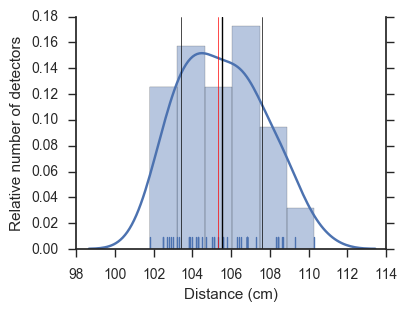

In [33]:
bicorr_plot.histogram_metrics(np.asarray(det_distance_df['Distance (cm)']),'Distance (cm)','Relative number of detectors')


I don't know where this error is coming from, so I will just continue on...

One nice thing about this distribution is that there are not really any "extremes." The

## Look at energy values for 1 m. vs. average (1.05522 m)

Look at 25 ns, which is right in the middle of the neutron distribution. 

In [12]:
t = 25
print(bicorr.convert_time_to_energy(t,distance=1))
print(bicorr.convert_time_to_energy(t,distance=1.05522))
print(bicorr.convert_time_to_energy(t,distance=1.05522)/bicorr.convert_time_to_energy(t,distance=1))

8.407646446907751
9.361823922980244
1.1134892484000003


So the 5.5% change in distance translates to an 11% change in energy for a 25 ns time of flight.

In [13]:
t = 50
print(bicorr.convert_time_to_energy(t,distance=1))
print(bicorr.convert_time_to_energy(t,distance=1.05522))
print(bicorr.convert_time_to_energy(t,distance=1.05522)/bicorr.convert_time_to_energy(t,distance=1))

2.101911611726938
2.340455980745061
1.1134892484000003


Again, an 11% change in energy for a 50 ns time of flight. This is equal to 1.05522^2. 

In [14]:
1.05522**2

1.1134892484

There we go. So whatever the ratio of distances is, the energy calculations will be off by that amount squared.

This really makes me think we need to go back to the original cced files, calculate the energies for each interaction, and then remake the `bicorr_hist_master` from that. This will be a lot of work.

## Consider distribution of energies

In [19]:
det_distance_df.head()

,Channel,Distance (cm)
0,1,106.5
1,2,105.1
2,3,103.8
3,4,103.3
4,5,102.5


C:\Users\pfsch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


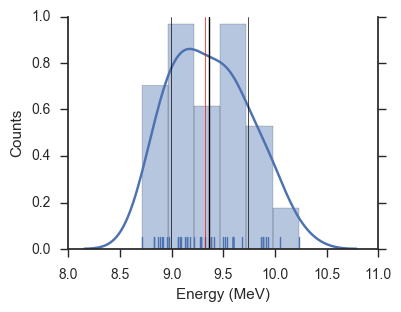

In [30]:
t = 25
energies = [bicorr.convert_time_to_energy(t,distance=dist) for dist in det_distance_df['Distance (cm)']/100]
bicorr_plot.histogram_metrics(energies, xlabel='Energy (MeV)', ylabel='Counts')

In [31]:
pd.DataFrame([bicorr.convert_time_to_energy(t,distance=dist) for dist in det_distance_df['Distance (cm)']/100]).describe()

,0
count,45.000000
mean,9.365541
std,0.376246
min,8.713046
25%,9.076231
50%,9.322474
75%,9.589963
max,10.228818


C:\Users\pfsch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


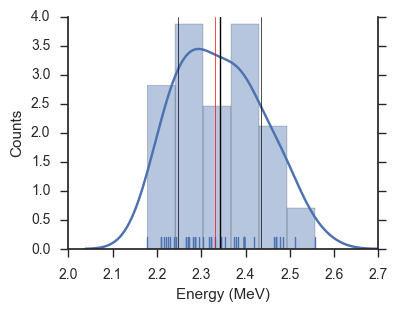

In [27]:
t = 50
energies = [bicorr.convert_time_to_energy(t,distance=dist) for dist in det_distance_df['Distance (cm)']/100]
bicorr_plot.histogram_metrics(energies, xlabel='Energy (MeV)', ylabel='Counts')

In [29]:
pd.DataFrame([bicorr.convert_time_to_energy(t,distance=dist) for dist in det_distance_df['Distance (cm)']/100]).describe()

,0
count,45.000000
mean,2.341385
std,0.094061
min,2.178261
25%,2.269058
50%,2.330619
75%,2.397491
max,2.557205


In [15]:
dt_bin_edges = np.arange(0,200,2)
print(dt_bin_edges)

[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198]


In [17]:
energy_bin_edges = np.asarray(np.insert([bicorr.convert_time_to_energy(t) for t in dt_bin_edges[1:]],0,10000))
print(energy_bin_edges)

[  1.00000000e+04   1.31369476e+03   3.28423689e+02   1.45966084e+02
   8.21059223e+01   5.25477903e+01   3.64915210e+01   2.68100971e+01
   2.05264806e+01   1.62184538e+01   1.31369476e+01   1.08569815e+01
   9.12288026e+00   7.77334176e+00   6.70252427e+00   5.83864337e+00
   5.13162015e+00   4.54565660e+00   4.05461345e+00   3.63904365e+00
   3.28423689e+00   2.97889968e+00   2.71424537e+00   2.48335493e+00
   2.28072006e+00   2.10191161e+00   1.94333544e+00   1.80205042e+00
   1.67563107e+00   1.56206273e+00   1.45966084e+00   1.36700807e+00
   1.28290504e+00   1.20633127e+00   1.13641415e+00   1.07240388e+00
   1.01365336e+00   9.59601722e-01   9.09760912e-01   8.63704640e-01
   8.21059223e-01   7.81495989e-01   7.44724919e-01   7.10489323e-01
   6.78561342e-01   6.48738152e-01   6.20838732e-01   5.94701112e-01
   5.70180016e-01   5.47144839e-01   5.25477903e-01   5.05072956e-01
   4.85833860e-01   4.67673463e-01   4.50512605e-01   4.34279259e-01
   4.18907767e-01   4.04338183e-01

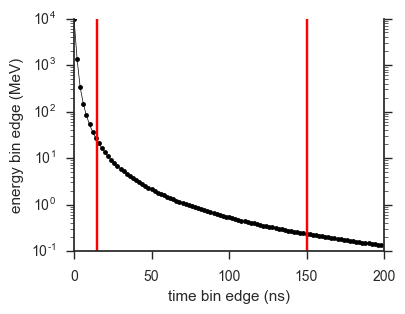

In [18]:
plt.figure(figsize=(4,3))
plt.plot(dt_bin_edges,energy_bin_edges,'.-k',linewidth=.5)
plt.axvline(15,color='r')
plt.axvline(150,color='r')
plt.yscale('log')
plt.xlabel('time bin edge (ns)')
plt.ylabel('energy bin edge (MeV)')
sns.despine(right=False)
plt.show()

* What is the distribution?
* What are the extremes?
* For a 25 ns event, what is the corresponding energy distribution?

Look at `dt_bin_edges` -> `energy_bin_edges`. How different are the edges for the extreme distances?

Evaluate how much would have to go into updating the analysis to incorporate this. 

* Do I have to go back to the bicorr individual events? Should I just save a second bicorr_hist_master in energy units, specific to each detector?
* If energy bin edges are different for each detector, this would make it nearly impossible to add the `bhp` together across pairs. Would have to define energy bin edges for all of them, and then time and energy `bhp` distributions would be different for each.

# Summary

The most extreme difference in energy due to different distances is over 17%, so I need to go back to the `bicorr` file and produce a `bhm_e` on an event-by-event basis. 

See: `methods > build_bhm_with_energy.ipynb`.